# SOUL Project Phase I
# 테라-루나 코인 붕괴 분석하기


## Part 2. LSTM으로 데이터 fitting하기

### RNN과 LSTM에 대한 간략한 소개

본 프로젝트에서 활용할 LSTM(Long Short-Term Memory)은 순환 신경망(Recurrent Neural Network, RNN)의 일종으로 1997년 개발되어 지금까지도 시계열 데이터 예측 분야에서 가장 널리 활용되는 딥러닝 모델이다.

간단하게 RNN과 LSTM에 대해 설명해보겠다. 우선 RNN은 시계열 데이터를 다루기 위해 고안된 가장 기초적인 심층신경망 구조이다. 일반적으로, RNN은 아래와 같은 수식으로 표현된다:

$h_t = \text{RNN}(x_t, h_{t-1})$

$t$는 정수로 시간 스텝(time step)을 나타내며, $h_t$는 시간 스텝 $t$에서의 은닉 상태(hidden state)를 말한다. 여기서 은닉 상태 $h_t$란 초기 상태부터 시간 스텝 $t$까지의 정보를 함축적으로 표현하고 있으리라 기대되는, 숨어있는 어떤 $n$차원의 벡터이다.

예를 들어, 우리의 뇌를 어떤 방식으로 디지털화하여 저장했다고 생각해보자. 시간 스텝 $t-1$에서 뉴런의 연결 상태는 벡터 $h_{t-1}$이 될 것이다. 한편 우리 뇌는 시신경을 통해 (혹은, 디지털 뇌의 경우 카메라를 통해) 매 시간 스텝마다 새로운 정보 $x_t$를 입력 받는다. 정보를 입력 받은 뒤 현재 시간 스텝 $t$에서의 뉴런 연결 상태는 이전 뉴런 연결 상태 $h_{t-1}$과는 다를 것이다. 우리는 뉴런 연결 상태가 시간에 따라 변화(evolve)하는 정확한 메커니즘을 모르지만, 어쨌든 이전 뉴런 연결 상태와 현재 입력 정보에 따라 결정되는 적절한 함수 관계가 존재하리라 가정할 수 있다. 그 함수 관계를 어떻게 "학습"할 수는 없을까?

딥러닝을 배운 사람이라면 복잡한 함수는 심층신경망이 근사해주리라 기대할 수 있다. 대부분의 시스템에서 $\text{RNN}()$으로 나타낸 이 함수는 복잡한 함수이기 때문에 심층 신경망을 이용하여 구현된다. 우리는 이전에 심층 신경망에서 각각의 층 $\rho(Ax+b)$이 하는 역할에 대해 알아보았다. 여러 층을 합성하여 신경망 구조를 깊게 쌓을수록 심층 신경망의 표현력(expressivity)이 증가한다. 위에서 $\text{RNN}()$ 함수는 표현력이 충분히 좋은 심층 신경망으로 구현되기에, $x_t$와 $h_{t-1}$, $h_t$의 관계를 근사적으로 표현할 수 있으리라 기대할 수 있다.

요약하자면, RNN의 목적은 [이전 시간 스텝까지의 정보를 함축적으로 표현하는 $h_{t-1}$]과 [현재 상태에 대한 정보 $x_t$]를 입력으로 받아 
[현재 시간 스텝까지의 정보를 함축적으로 표현하는 $h_t$]를 출력하는 함수를 인공신경망으로 근사하는 것이라고 할 수 있겠다.

그런데 아직 우리는 심층신경망 $\text{RNN}()$의 구조에 대해서 아무것도 논한 것이 없다. 정말 아무 생각 없이 머리에 힘을 빼고 RNN을 설계하면 아래와 같을 것이다:

$\text{RNN}(x_t, h_{t-1}) = \rho(W_1x_t + W_2h_{t-1})$

위의 식에서 $W_1$과 $W_2$는 모두 행렬이고, $\rho()$는 활성화 함수이다. $W_1$은 입력(input)을 은닉 상태(hidden state)와 같은 차원의 벡터로 변환해주는 행렬이기 때문에 $W_{ih}$로 새로 이름 붙이고, $W_2$는 은닉 상태를 은닉 상태로 매핑하는 행렬이기 때문에 $W_{hh}$로 이름을 바꿔주자. 또한, 평행이동을 담당하는 바이어스 $\mathbf{b}_{ih}$와 $\mathbf{b}_{hh}$를 추가하고, 활성화 함수 $\rho()=\tanh()$를 사용하자. 그러면

$\text{RNN}(x_t, h_{t-1}) = \tanh(W_{ih}x_t + b_{ih} + W_{hh}h_{t-1} + b_{hh})$

이것이 기본 RNN (Vanilla RNN) 구조이다. 영어로 Vanilla RNN으로 부르는 이유는 마치 바닐라맛 아이스크림처럼 기본이 되는, 다소 밋밋한 구조이기 때문이다.

LSTM은 $\text{RNN}()$으로 표시한 심층신경망 함수를 기본 RNN 구조에 비해 복잡하게 정의했을 뿐이다. 우선 수식적인 정의는 아래와 같다:

$\begin{aligned} i_t &= \sigma(W_{ii}x_t+b_{ii}+W_{hi}h_{t-1}+b_{hi}) \\
f_t &= \sigma{}(W_{if}x_t+b_{if}+W_{hf}h_{t-1}+b_{hf}) \\ g_t &= \tanh(W_{ig}x_t+b_{ig}+W_{hg}h_{t-1}+b_{hg}) \\ o_t &= \sigma(W_{io}x_t+b_{io}+W_{ho}h_{t-1}+b_{ho}) \\ c_t&=f_t\odot c_{t-1}+i_t\odot g_t \\ h_t &= o_t \odot \tanh(c_t) \end{aligned}$

당연하지만 지금 단계에서 전부 읽고 이해할 필요는 굳이 없다. 중요한 것은 셀 상태(cell state) $c_t$가 추가되었다는 것인데, 이것도 넓은 의미에서 은닉 상태의 개념에 포함된다고 할 수 있지만 조금은 특별하다. LSTM은 gated memory로 불리는 구조를 활용하여 선택적으로 셀 상태에 저장된 정보 중 일부를 잊어버리거나 새로운 정보를 추가하는 기능을 수행하기 때문에 기본 RNN에 비해 높은 성능을 달성한다. LSTM의 자세한 구조에 관하여서는 더 자세히 설명되어 있는 다음 블로그의 글을 참고하자. [링크](https://databasecamp.de/en/ml/lstms)

아직 빠진 내용이 있다. 입력으로 주어지는 시계열 데이터 $x_t$와 은닉 상태 $h_t$가 있는 것은 알겠는데, 그렇다면 RNN의 출력은 무엇일까? 즉, 좀 전의 디지털 뇌 복제 예시에서 인간의 행동에 해당하는 "출력"을 논해야 한다. 시간 스텝 $t$에서 LSTM의 원래 출력은 $h_t$이지만, 우리는 선형 층(Linear Layer)을 추가하여 $y_t=W_\text{out} h_t +b_\text{out}$을 출력값으로 활용하고자 한다. 이것이 반드시 필요한 이유는 LSTM에서 벡터 $h_t$의 각 성분이 $-1$부터 $1$ 사이의 값을 가지기 때문에 **출력값이 이 범위를 벗어나는 경우 제대로 된 학습이 불가능하기 때문이다**. 행렬 $W_\text{out}$을 통과 시키면 범위에 의한 제약 조건이 사라지기 때문에 $-1$보다 작거나 $1$보다 큰 데이터를 fitting하지 못하는 문제를 해결할 수 있다.

본 프로젝트에서 입력 $x_t$는 스테이블 코인과 관련한 $1$분 간격의 시계열 데이터이며 출력 $\hat{y}_t$는 $m$분 후 $x_t$, 즉 $x_{t+m}$이 되도록 학습할 것이다. 여기서 $m$은 임의의 양의 정수 값으로 조절 가능하다. 구체적으로는, $y_t=x_{t+m}$으로 두고 총 시간 스텝의 수를 $T$, 입력 $x_t$의 차원을 $N$이라 할 때 다음의 손실 함수

$L=\frac{1}{NT}\sum_{t=1}^{N}\|\hat{y}_t-y_t\|^2$

을 최소화할 것이다.


### 백엔드 연결 및 초기 셋업

자, 이제 본격적으로 코딩을 시작해보자.

이번에도 똑같이 구글 백엔드에 있는 컴퓨터를 나의 구글 드라이브에 연결시킨다.

In [1]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

ModuleNotFoundError: No module named 'google'

그리고 `%cd` 커맨드를 이용하여 기본 폴더에서 SOUL 프로젝트를 위해 새로 만든 "drive/MyDrive/SOUL" 폴더로 이동한다.

In [ ]:
%cd drive/MyDrive/SOUL/
%ls

/content/drive/MyDrive/SOUL
 10-minutes-to-pandas.ipynb   LUNAUSDT-1m-2022-05-07.csv
 LUNAUSDT-1h-2022-05-06.csv  'SOUL_PhaseI_Part2_[0.01][120][1][2][5].jpg'
 LUNAUSDT-1h-2022-05-07.csv  'SOUL_PhaseI_Part2_[0.01][240][1][2][5].jpg'
 LUNAUSDT-1m-2022-05-06.csv   SOUL-Project-Phase-I-Part-1.ipynb


각종 라이브러리를 불러오자. 페이스북 인공지능 연구팀 주도로 개발된 딥러닝 라이브러리인 파이토치(PyTorch)가 앞으로 사용할 핵심 라이브러리가 될 것이고, 보조적으로 Part 1에서 소개했던 NumPy, Pandas, Matplotlib, 그리고 이번 Part 2에서 새로 추가된 호환성 좋은 오픈소스 머신러닝 라이브러리 scikit-learn을 사용한다.

PyTorch(`torch`)의 경우 우선 라이브러리 전체를 `import torch`로 불러오고, 그 중 자주 사용하는 신경망 패키지 `nn`과 `optim`은 앞의 `torch.`을 생략하고 사용하기 위해 따로 `import` 해준다. 예를 들어, 선형 변환 기능을 수행하는 `torch.nn.Linear()` 클래스의 객체를 생성하기 위해 앞의 `torch.`를 생략하고 `nn.Linear()`처럼 간단하게 호출할 수 있다.



scikit-learn(`sklearn`)의 경우 데이터 전처리를 패키지인 `sklearn.preprocessing`에서 `StandardScaler`만을 사용할 것이기 때문에 해당 클래스만 선택적으로 `import`한다.



In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'numpy'

또한 하이퍼파라미터를 정의하겠다. 하이퍼파라미터란 학습 과정 중에서 고정되어 있는 변수값을 의미하며, 대표적으로 경사하강법에서의 학습률(learning rate)과 학습 횟수(number of epochs)가 있다. 이를 각각 `learning_rate`와 `num_epochs` 변수로 지정하자.

또한, 앞서 우리가 출력 $\hat{y}_t$를 $m$분 후 $x_t$가 되도록, 즉 $\hat{y}_t\sim x_{t+m}$가 되도록 학습하기로 했음을 기억하자. $m$을 코드 상에서 `minutes_delayed`로 정의하고, 또 LSTM에서의 입력 $x_t$의 차원과 은닉 상태 $h_t$의 차원을 각각 `input_dim`과 `hidden_dim`으로 정의하자. 그러면 학습에서 사용될 하이퍼파라미터는 아래와 같다.

In [ ]:
learning_rate = 0.01
num_epochs = 240
minutes_delayed = 1
input_dim = 2
hidden_dim = 5

### 루나 거래 정보 불러오기

.csv 형태의 루나 코인 거래 정보 데이터를 `pd.read_csv`를 이용하여 불러온다. 이번에는 5월 7일 데이터를 사용했다.

In [ ]:
df = pd.read_csv('LUNAUSDT-1m-2022-05-07.csv')
df.columns = ["open_time", "open", "high", "low", "close", "volume", 
              "close_time", "quote_asset_volume", "number_of_trades", 
              "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", 
              "ignore"]

또한 GPU 가속화를 위해 `torch.device()`로 사용할 가속기를 설정한다. `torch.cuda.is_available()`은 Nvidia사의 GPU가 컴퓨터와 연결되어 있는지를 확인하여 있으면 `true`, 없으면 `false`를 반환한다. 만약 GPU가 연결되어 있음이 확인될 경우(`true`) 학습에 사용할 기기를 첫번째 (기본) GPU `"cuda:0"`로 설정하고, GPU가 연결되어 있지 않을 경우(`false`) GPU 대신 `"cpu"`를 사용한다.

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

`df`의 모습을 확인해보자.

In [ ]:
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1651881660000,77.44,77.49,77.36,77.45,1982.91,1651881719999,153552.2638,220,1047.34,81111.5334,0
1,1651881720000,77.45,77.50,77.28,77.28,3801.21,1651881779999,294168.0827,256,1539.21,119153.8230,0
2,1651881780000,77.28,77.29,77.15,77.20,2155.87,1651881839999,166416.0020,352,1030.94,79573.2684,0
3,1651881840000,77.20,77.36,77.19,77.30,1233.22,1651881899999,95316.9767,129,736.41,56910.2374,0
4,1651881900000,77.31,77.34,77.27,77.28,1217.37,1651881959999,94109.8165,131,679.50,52530.8662,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1434,1651967700000,68.40,68.42,68.28,68.35,1823.22,1651967759999,124629.0183,282,549.50,37561.0569,0
1435,1651967760000,68.35,68.44,68.29,68.32,3074.76,1651967819999,210192.2858,319,1211.75,82841.4013,0
1436,1651967820000,68.33,68.33,67.92,67.95,10146.95,1651967879999,691020.9842,1100,3123.07,212591.4869,0
1437,1651967880000,67.96,68.12,67.86,68.08,11640.93,1651967939999,791519.1316,1003,6278.73,426905.4207,0


### 데이터 가공하기

Part 1에서 (초보인) 우리에겐 시간에 따른 OHLCV(Open, High, Low, Close, Volume) 데이터만 있으면 충분하다고 이야기한 적이 있다. 사실은 OHLCV도 데이터량이 너무 많고, 실제로는 Open Price와 Volume만 알면 충분하다. 이유는 1분 안에 가격이 급격하게 변하는 경우는 흔하지 않으며, 따라서 Open ~ High ~ Low ~ Close 모두 비슷하기 때문이다. 또한, Unix time으로 나타내어지는 시간 정보 역시 단위 간격이 1분임을 알고 있다면 그다지 필요하지 않은 정보이다. 따라서, `"open"`과 `"volume"` 열만을 가져온다.

`df.iloc[]`는 `df`에서 지정한 범위의 값을 새로운 `Dataframe` 객체로 반환한다는 사실을 기억하자. 이번에 사용하는 `df.loc[]`는 `df.iloc[]`와 기능은 동일하지만 선택하고자 하는 열에 해당하는 헤더 문자열을 리스트로 입력받는다는 차이점이 있다.


In [ ]:
df = df.loc[:, ["open", "volume"]]

다시 `df`를 출력하면 아래와 같다.

In [ ]:
df

,open,volume
0,77.44,1982.91
1,77.45,3801.21
2,77.28,2155.87
3,77.20,1233.22
4,77.31,1217.37
...,...,...
1434,68.40,1823.22
1435,68.35,3074.76
1436,68.33,10146.95
1437,67.96,11640.93


**입력** $x_t$와 (변형된) LSTM의 출력 $\hat{y}_t$, 희망하는 출력 $y_t$ 각각 `inputs`, `outputs`, `outputs_cmp`라 이름 붙이자.

`inputs`와 `outputs_cmp`는 `minutes_delayed`만큼 시간 축 상으로 평행이동 된 관계에 있다. 따라서, `inputs`는 `0`번째 시간 스텝부터 `len(df)-minutes_delayed-1`번째 시간 스텝까지, 그리고 `outputs_cmp`는 `minutes_delayed`번째 시간 스텝부터 `len(df)-1`번째 시간 스텝까지를 선택한다.

In [ ]:
inputs = df.iloc[0:len(df)-minutes_delayed, :]
outputs_cmp = df.iloc[minutes_delayed:len(df), :]

다음으로는 `StandardScaler()`를 사용하여 변수를 표준화한다. 변수를 표준화하지 않으면 많은 경우 학습 성능이 떨어진다. 이에 대해 여러가지 설명이 가능한데, 극단적인 경우를 생각하면 이해가 쉽다.

예를 들어 키와 연령 데이터를 바탕으로 몸무게를 추정하는 딥러닝 모델을 만든다고 하자(실제로 이러는 경우는 잘 없지만, 예시로서만 받아들이자). 키는 미터나 센티미터로 보통 측정하지만, 누군가가 데이터에 장난을 쳐놓아서 키 데이터를 나노미터(nm) 단위로 변경한 경우를 생각할 수 있다.

학습 과정에서는 가중치 값들과 입력 데이터값들이 곱해지고, 더해지고, 또 활성화 함수를 통과한다. 그런데 데이터가 표준화되지 않은 상태에서 학습을 그대로 진행하면 nm 단위의 (절대값이 매우 큰) 데이터가 가중치에 고스란히 곱해지고, 이것이 활성화 함수를 통과하게 된다. 활성화 함수로 시그모이드(sigmoid) 함수를 사용한다고 하면, 아마도 아주 크거나 아주 작은 값이 입력으로 들어올테니 함수값은 0 또는 1로 포화(saturate)될 것이다.

이와 같은 문제를 방지하기 위해 데이터의 단위와 평균값에 의한 영향을 상쇄하고자 입력 데이터를 표준화하여 사용하게 된다. 총 $n$개의 데이터 중 $i$ 번째 데이터포인트를 $X_i$라고 하면, 평균 $m$과 표준편차 $s$은 아래 공식을 통해 구할 수 있다.

$m=\frac{1}{n}\sum_{i=1}^{n}{Xi}$

$s=\sqrt{\frac{1}{n-1}\sum_{i=1}^{n}{(X_i-m)^2}}$

위의 평균과 표준편차를 이용하여 데이터를 표준화하면
$\tilde{X}_{i}=\frac{X_i - m}{s}$
를 얻는다.

In [ ]:
ss = StandardScaler()
inputs = ss.fit_transform(inputs)
outputs_cmp = ss.transform(outputs_cmp)

`ss.fit_transform()`을 통과한 `inputs`와 `outputs_cmp`의 `type`에 대해 알아보자. 원래는 `pandas.Dataframe` 객체였지만, 이제는 모두 `numpy.ndarray`로 변환되었음을 확인할 수 있다.

In [ ]:
print(type(inputs), type(outputs_cmp))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


PyTorch에서는 `torch.Tensor` 객체만을 다루기 때문에 위의 `numpy.ndarray`형의 자료를 형변환(type conversion) 해주어야 한다. 여기서 `.to(device)`는 사용할 기기를 지정해주는 역할을 한다.

In [ ]:
inputs = torch.Tensor(inputs).to(device)
outputs_cmp = torch.Tensor(outputs_cmp).to(device)

다시 한 번 `type`을 살펴보자. `torch.Tensor` 객체로 잘 변환된 것을 확인할 수 있다.

In [ ]:
print(type(inputs))
print(type(outputs_cmp))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


이제 텐서의 크기를 확인해보자. 간단하게 `.size()` 함수를 호출하여 확인할 수 있다.

In [ ]:
print(inputs.size())
print(outputs_cmp.size())

torch.Size([1438, 2])
torch.Size([1438, 2])


즉, 두 `inputs`와 `outputs_cmp` 모두 시간 차원이 1438개 있고 특징(feature) 차원이 2개 있는 텐서이다. 하지만, PyTorch에서 제공되는 nn.LSTM 클래스의 객체를 사용하기 위해서는 시간 차원과 특징 차원 사이에 배치 차원을 (반드시) 만들어주어야 한다. 배치는 동일한 형태의 데이터 여러 개를 뭉쳐서 하나로 학습시킬 때 사용하는데, 이와 관련하여서는 딥러닝 입문 교재를 참고하기를 바란다. 우선 이번 예제에서는 배치 크기를 1로 둘 예정이므로 그다지 상관이 없다.

nn.LSTM 클래스에서 요구하는대로, `.view()` 함수를 통해 두 텐서의 `.size()`를 변경해주자.

In [ ]:
inputs = inputs.view(len(inputs), 1, -1)
outputs_cmp = outputs_cmp.view(len(outputs_cmp), 1, -1)

In [ ]:
print(inputs.size())
print(outputs_cmp.size())

torch.Size([1438, 1, 2])
torch.Size([1438, 1, 2])


두 텐서의 크기가 잘 변경되었음을 확인할 수 있다.

### LSTM과 Linear Layer 정의하기

아래와 같이 `nn.LSTM()` 객체를 생성한다.

LSTM을 생성할 때 첫번째 변수는 입력 $x_t$의 차원이고, 두번째 변수는 은닉 상태 $h_t$의 차원이다. 앞서 학습의 용이함을 위해 $x_t$의 차원 `input_dim`은 `2`, $h_t$의 차원은 `hidden_dim`은 `5`로 설정하였다는 것을 기억하자.

In [ ]:
lstm = nn.LSTM(input_dim, hidden_dim).to(device)  # nn.LSTM(2, 5)과 동일

앞서 언급했듯 LSTM에서는 출력으로 $h_t$가 그대로 나오기 때문에 이를 변환해주는 선형 변환이 필요하다. 따라서 아래와 같이 `nn.Linear(hidden_dim, input_dim)`를 생성한다. 엄밀히 말하자면 행렬을 곱한 다음에 벡터를 더하는 역할을 수행하기 때문에 선형 변환이 아니라 어파인 변환(Affine Transformation)이라고 부르지만, PyTorch에서는 편의상 선형 변환으로 부른다.

In [ ]:
linear = nn.Linear(hidden_dim, input_dim).to(device)  # nn.Linear(5, 2)과 동일

### Optimizer와 Loss function 정의하기

아래와 같이 `optim.Adam` 객체와 `nn.MSELoss` 객체를 정의한다.

여기서 `optim`으로 줄여쓰기로 한 `torch.optim`은 경사하강법(Gradient Descent)을 비롯한 각종 최적화 기법을 쉽게 적용할 수 있도록 돕는 패키지이다. 그리고 `optim.Adam`은 Adam optimizer를 정의하기 위한 클래스이고, 여기서 말하는 Adam은 이전에 설명했던 고급 최적화 기법의 일종으로 모멘트 추정(moment estimation) 등의 고급 기법을 적용한 경사하강법의 변형 버전이다.

리스트 안에 `*lstm.parameters()`, `*linear.parameters()`가 리스트로 묶여서 대입된 것을 확인할 수 있는데 그 뜻은 그래디언트를 업데이트할 때 (즉, `optimizer.step()` 함수가 호출될 때) 리스트에서 관리하기로 지정한 파라미터들만 업데이트하도록 하겠다는 의미이다.

`nn.MSELoss` 객체는 두 텐서의 평균제곱합(Mean Squared Error, MSE)를 계산해준다. 앞서 정의한 손실함수 $L=\frac{1}{NT}\sum_{t=1}^{N}\|\hat{y}_t-y_t\|^2$를 계산하기 위해 활용할 것이다.

In [ ]:
optimizer = optim.Adam([*lstm.parameters(), *linear.parameters()], lr=learning_rate)
loss_function = nn.MSELoss().to(device)

### 그래프 플로팅(plotting)을 위한 matplotlib 객체 생성하기

그래프 플로팅을 위해 `plt.subplots()` 함수를 사용한다. `plt.subplots(1, 3)`은 1x3(세로로 1개, 가로로 3개)의 배열로 총 3개의 그래프를 한 창에 띄울 수 있도록 해준다. 여기서 `fig`는 하나의 창에 대응되는 `matplotlib.pyplot.Figure` 객체이고, `ax1, ax2, ax3`는 세 개의 그래프에 대응되는 `matplotlib.pyplot.Axes` 객체이다.

다양한 함수를 적용하여 x축과 y축 라벨을 설정하고, 또 각 그래프에서 그리드 옵션을 켤 수 있다.

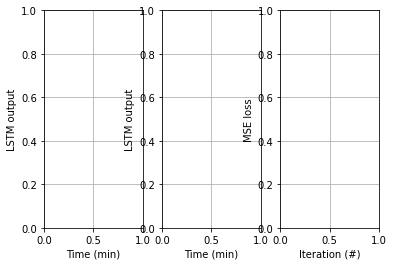

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("LSTM output")
ax1.grid(True)
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("LSTM output")
ax2.grid(True)
ax3.set_xlabel("Iteration (#)")
ax3.set_ylabel("MSE loss")
ax3.grid(True)

첫번째와 두번째 그래프(`ax1`과 `ax2`)에서 비교하고자 하는 참값인 `outputs_cmp`를 플롯한다.

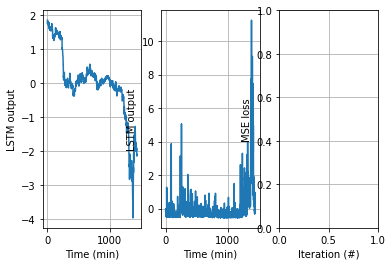

In [ ]:
ax1.plot(outputs_cmp.detach().numpy()[:, 0, 0], label="true data")
ax2.plot(outputs_cmp.detach().numpy()[:, 0, 1], label="true data")
fig

### 학습하기

LSTM은 은닉 상태와 셀 상태를 동시에 가지고 있는데, 이 둘의 차원은 동일하다. 두 초기 변수를 표준 정규 분포를 따르는 랜덤 변수로 초기화한 후, `hidden_init`으로 묶어서 LSTM에 전달할 것이다. 우선 `torch.manual_seed(1)`을 통해 난수 생성 시드를 고정하고 `hidden_init = (h, c)`를 정의한다.

In [ ]:
torch.manual_seed(1)
hidden_init = (torch.randn(1, 1, hidden_dim).to(device), torch.randn(1, 1, hidden_dim).to(device))

학습은 아래와 같은 반복문을 통해 진행되는데, 그에 앞서 PyTorch 프레임워크에 대한 간략한 설명과 함께 학습 과정의 개요를 설명하겠다.

먼저 PyTorch 프레임워크에서 가장 핵심적으로 사용하는 두 개의 명령어가 있는데, 바로 `loss.backward()`와 `optimizer.step()`이다. 먼저 `loss.backward()`는 계산된 `loss` 값부터 시작하여 그래디언트 역전파(Gradient backpropagation)를 **자동으로** 수행한다. 구체적으로는 자동 미분(autodiff)로 불리우는, 유향 비순환 그래프(Directed Acyclic Graph, DAG)라는 자료 구조에 기반하여 그래디언트 역전파를 수행한다. 중요한 것은, 우리가 그래디언트를 일일이 계산할 필요 없이 라이브러리에서 **알아서** 처리해준다는 것이다. PyTorch를 비롯하여 TensorFlow와 같은 오늘날의 딥러닝 프레임워크에서는 자동 미분 기능의 존재가 당연시되지만, 10년 전만 하더라도 랩실에서 대학원생들이 일일이 계산해가면서 하던 일이었다는 사실을 기억하면 대단한 성과라고 할 수 있다.

앞서 **Optimizer와 Loss function 정의하기** 단계에서 optimzer 객체를 정의했던 것을 기억하자. `torch.optim.Optimizer` 클래스를 상속받아 만들어지는, `optim.Adam`과 같은 다양한 `Optimizer`의 가장 큰 장점은 `loss.backward()`를 통해 계산된 그래디언트 값을 바탕으로 알아서 파라미터를 업데이트해준다는 것이다. 구체적으로, `loss.backward()`로 그래디언트 역전파가 이루어진 이후 `Optimizer` 객체들은 자신이 관리하기로 되어 있는 파라미터들에 대해 그래디언트 값을 **누적하여** 저장하고 있다가, 마지막에 `optimizer.step()` 함수가 호출될 때 사용자가 신경쓰지 않아도 **자동으로** 그래디언트를 업데이트해준다. 대신, 누적된 그래디언트 값을 중간중간 클리어(clear) 해줄 필요가 있다. 이것이 `optimizer.zero_grad()`가 하는 역할이다. 학습 횟수인 `num_epochs`(+1)번만큼 학습이 진행되는데, 각 학습 단계에서 가장 먼저 `optimizer.zero_grad()`를 호출하여 `optimizer`가 저장하고 있던 그래디언트 값을 비워주자.

이후 입력 `inputs`가 초기 은닉값 `hidden_init`과 함께 `lstm`을 통과하고 `outputs`로 나오게 되는데, 이 값을 다시 `linear` 층에 통과시킨 다음 평균제곱합 오차를 계산하는 `loss_function`에 대입하여 해당 epoch에서의 `loss`를 계산한다. 이후 손실 함수 값을 추적하기 위해 빈 리스트로 초기화했던 `losses` 리스트에 `loss` 값을 좀 전에 언급한 유향 비순환 그래프(DAG)에서 `.detach()`한 후 `.numpy()`로 변환하여 저장해준다. 다음으로, `loss.backward()`를 통해 역전파 알고리즘을 수행한다. 역전파가 완료되었다면 계산된 그래디언트 값을 바탕으로 `optimizer.step()`을 통해 실제로 그래디언트 방향으로 가중치를 업데이트한다. 마지막으로, 중간 중간 `outputs` 값을 확인하기 위해 앞서 정의한 `ax1`과 `ax2` 객체에 그 값을 플로팅한다. 이후에는 같은 과정이 `for` 문에서 계속 반복되면서 학습이 진행된다.

In [ ]:
losses = []
for i in range(1, num_epochs+1):
    optimizer.zero_grad()     # optimizer에 누적된 gradient 0으로 초기화
    outputs, hidden = lstm(inputs, hidden_init)  # lstm 통과
    outputs = linear(outputs)                    # linear layer 통과
    loss = loss_function(outputs_cmp, outputs)   # loss 값 계산
    losses.append(loss.detach().numpy())         # 리스트에 loss 값 추가
    loss.backward()                              # 역전파 수행
    optimizer.step()                             # 가중치 업데이트
    if i in [1, num_epochs//12, num_epochs//6, num_epochs//3, num_epochs//2, num_epochs]:   # 중간 점검
        print("iteration", i)   # 몇 번째 iteration인지 출력 후 plotting 수행
        ax1.plot(outputs.detach().numpy()[:, 0, 0], label=f"{i}th iteration")
        ax2.plot(outputs.detach().numpy()[:, 0, 1], label=f"{i}th iteration")

iteration 1
iteration 20
iteration 40
iteration 80
iteration 120
iteration 240


학습이 완료되었다면 학습 횟수에 따른 손실 함수의 값 `losses`를 세번째 그래프(`ax3`)에 플롯한다. 플롯한 그래프를 표시하면 아래와 같다.

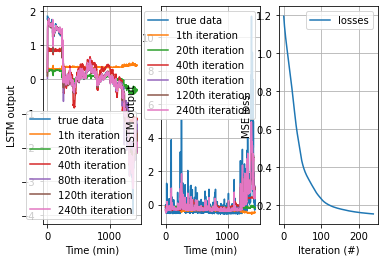

In [ ]:
ax3.plot(losses, label="losses")
ax1.legend()
ax2.legend()
ax3.legend()
fig

이후 이미지의 크기를 지정한 다음 .jpg 파일로 저장한다.

In [ ]:
fig.set_size_inches(24, 8)
fig.savefig(f"SOUL_PhaseI_Part2_[{learning_rate}][{num_epochs}][{minutes_delayed}][{input_dim}][{hidden_dim}].jpg", dpi=200)

아래와 같이 이미지가 잘 저장된 것을 확인할 수 있다.

![SOUL_PhaseI_Part2_[0.01][240][1][2][5].jpg](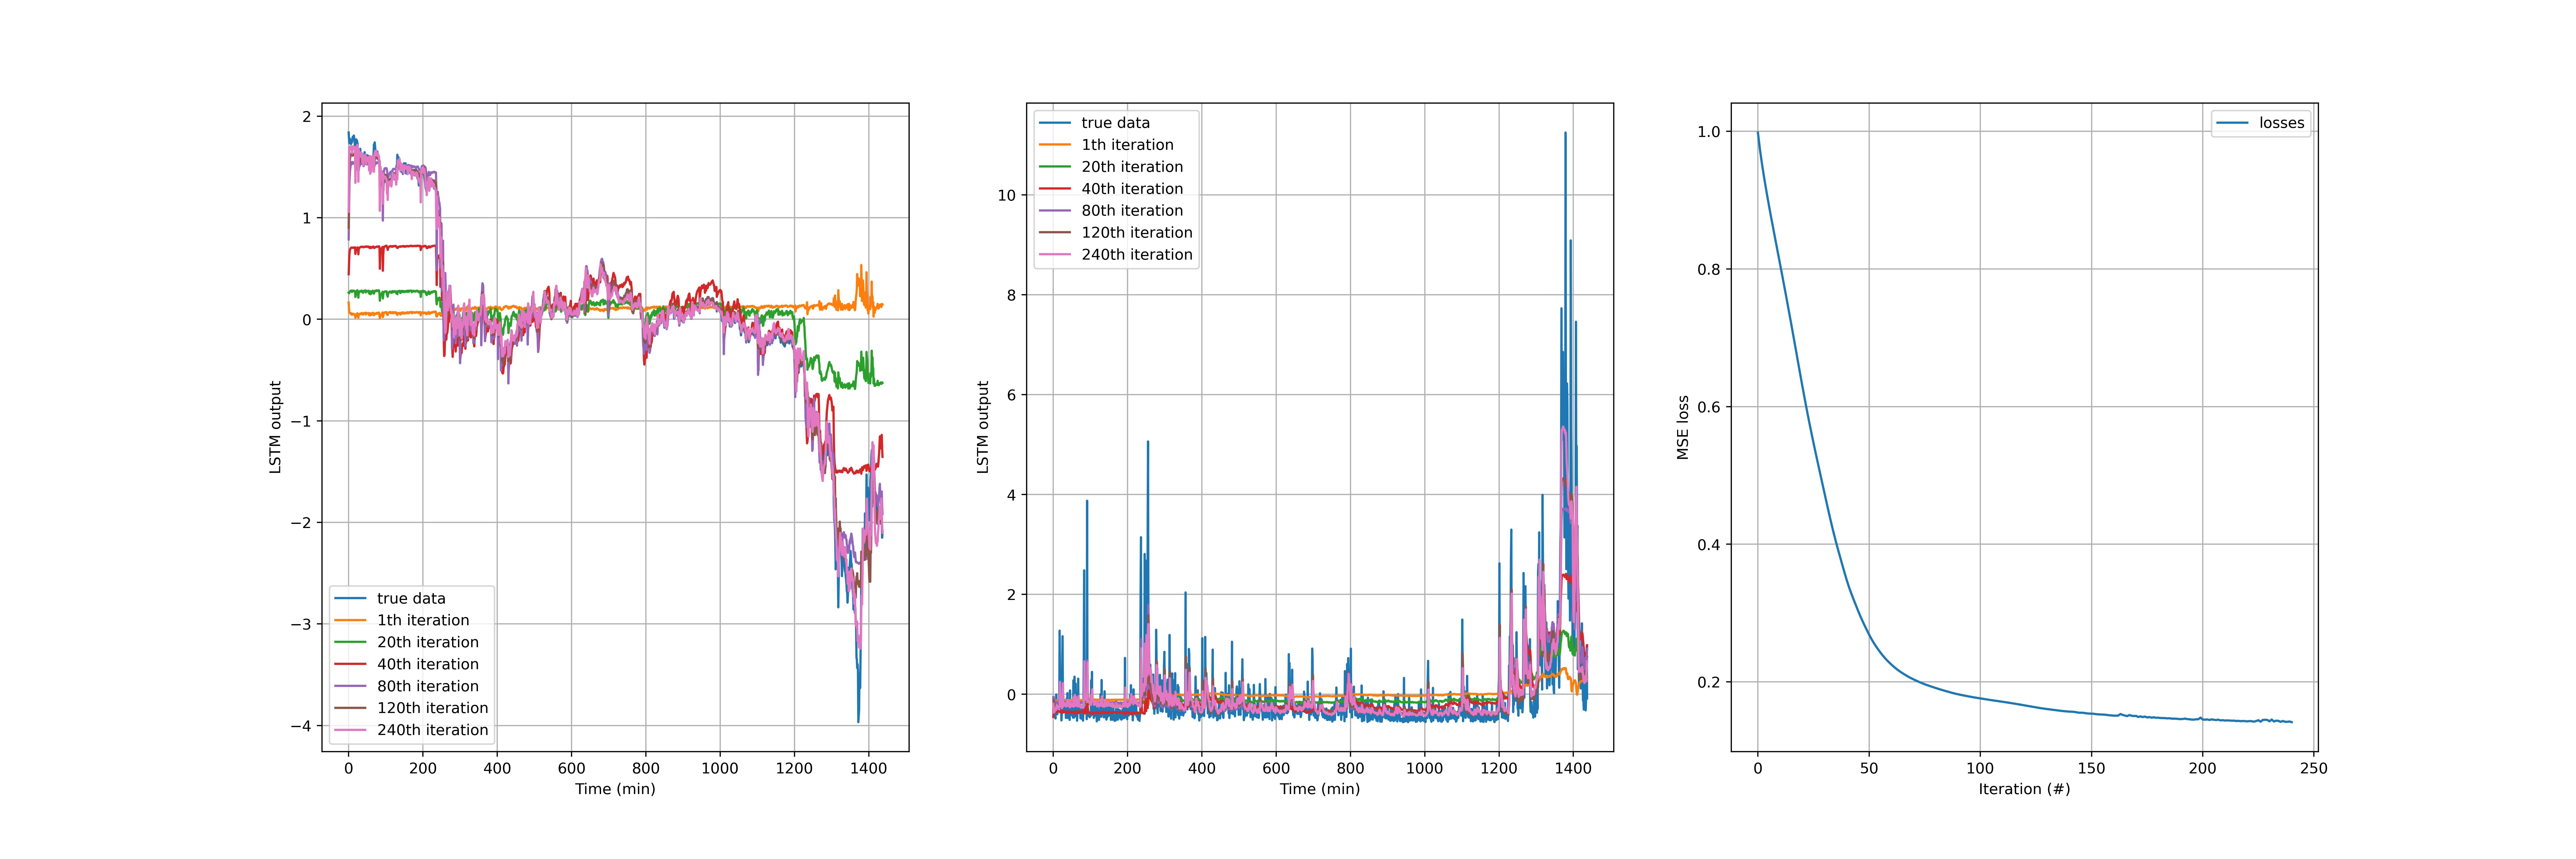)

### 교훈 및 마무리

PyTorch와 같은 딥러닝 프레임워크를 사용하는 가장 큰 이유는 역전파 알고리즘과 파라미터 업데이트를 직접 구현하지 않아도 라이브러리에서 자동으로 수행해주기 때문이다. 과거에는 컴퓨터가 있더라도 PyTorch처럼 자동화된 미분 연산을 수행하는 체계가 부재했기 때문에 인공지능을 연구하는 대부분의 사람들은 랩실에서 수식 계산에 시간을 쏟았다고 한다. 랩에서 중도 이탈하는 주된 이유 중 하나가 복잡한 수식 계산 때문이었다고 하니 잘 개발된 컴퓨터 라이브러리가 전세계 수많은 사람들의 커리어를 살렸다고 볼 수 있겠다.

이번 Part 2에서는 LSTM을 이용하여 주가 데이터를 피팅(Fitting)해보았다. 아마 하이퍼파라미터를 그대로 두었다고 하면 `240`번째 에폭에서의 `outputs`가 실제 데이터인 `outputs_cmp`와 거의 일치함을 확인할 수 있을 것이다. 다양한 하이퍼파라미터 조건에서 학습이 잘 진행되는지를 확인해보자. 특히, `minutes_delayed` 변수를 키워서 LSTM이 각각의 시간 스텝에서 60분 뒤의 Open Price와 Volume을 예측할 수 있는지 확인해보자. 또한 배치 크기를 키우려면 코드를 어떻게 수정해야하는지 생각해보는 것도 좋은 연습이 될 것이다.

그러나 지금 단계에서는 결과가 좋더라도 방심은 금물이다. 아직 훈련(training)을 진행했을 뿐 검증(validation)과 시험(testing) 단계가 남아있기 때문이다. 실제로는 훈련 데이터를 완전히 외워서 과적합(overfitting)된 경우, 이후 훈련 데이터에 등장하지 않은 새로운 데이터가 주어진 상황에서는 성능이 심하게 저하될 수가 있다. 다음 Part 3에서는 검증 데이터를 통해 최적의 하이퍼파라미터를 탐색하고, 시험 데이터를 통해 모델의 성능을 평가하도록 하겠다.